In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import ResNet50

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

tf.Tensor(33.9693, shape=(), dtype=float32)
tf.Tensor(33.9693, shape=(), dtype=float32)
tf.Tensor(38.293594, shape=(), dtype=float32)
tf.Tensor(38.29359, shape=(), dtype=float32)
tf.Tensor(36.940254, shape=(), dtype=float32)
tf.Tensor(36.940254, shape=(), dtype=float32)
tf.Tensor(74.06923, shape=(), dtype=float32)
tf.Tensor(74.06923, shape=(), dtype=float32)
tf.Tensor(66.510605, shape=(), dtype=float32)
tf.Tensor(66.510605, shape=(), dtype=float32)
tf.Tensor(52.92857, shape=(), dtype=float32)
tf.Tensor(52.928566, shape=(), dtype=float32)
tf.Tensor(78.4034, shape=(), dtype=float32)
tf.Tensor(78.4034, shape=(), dtype=float32)
tf.Tensor(140.47586, shape=(), dtype=float32)
tf.Tensor(140.47586, shape=(), dtype=float32)
tf.Tensor(111.39947, shape=(), dtype=float32)
tf.Tensor(111.39946, shape=(), dtype=float32)
tf.Tensor(121.93478, shape=(), dtype=float32)
tf.Tensor(121.93479, shape=(), dtype=float32)
tf.Tensor(122.77906, shape=(), dtype=float32)
tf.Tensor(122.779076, shape=(), dtype=float32)

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


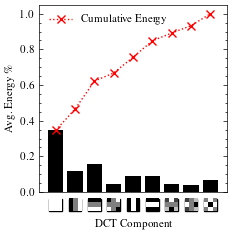

In [4]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
d = tf.cast(tf.stack(d), dtype=tf.float32)

fig,ax= plt.subplots(1,1)


dct_mean = np.zeros((9))

for l_num in range(0, len(conv_layers)):
	


	f = get_filter(model, l_num)
	title = conv_layers[l_num].name
	w = tf.reshape(tf.reduce_sum(f*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))

	print(tf.math.reduce_sum(w**2))
	print(tf.math.reduce_sum(f**2))


	dct_mean += tf.reduce_sum(w**2, axis=(1,2,3,4))/tf.math.reduce_sum(w**2)

dct_mean /= len(conv_layers)

bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], dct_mean)


for i, bar in enumerate(bars):
	# Load image

	dct_im = np.zeros((3,3))
	dct_im[pos[i]]=1
	#print(idct2(np.float16(dct_im)))
	img = idct2(np.float16(dct_im))

	# Create OffsetImage object
	im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

	# Get the x position of the bar's center
	x_position = bar.get_x() + bar.get_width() / 2

	# Place image below the x-axis label
	ab = AnnotationBbox(im, (x_position, 0), 
						xybox=(0, -5),  # Adjust the second value for distance under the label
						xycoords='data', 
						boxcoords="offset points", 
						pad=0, frameon=True, 
						box_alignment=(0.5, 1))

	# Add image to the axes
	ax.add_artist(ab)
ax.set_xticklabels([''] * w.shape[0])  # Set empty labels
ax.set_xlabel('DCT Component')
ax.xaxis.set_label_coords(0.5, -0.15)
ax.set_ylabel('Avg. Energy \%')
ax.set_box_aspect(1)


ax.tick_params(axis='x', which='both', length=0)
ax.set_box_aspect(1)

ax.plot(ax.get_xticks(), [np.sum(dct_mean[:i+1]) for i in range(dct_mean.shape[-1])], lw=1, c='r', ls=':', marker='x', label="Cumulative Energy")
ax.legend()


fig.tight_layout()

plt.show()

In [5]:
fig.savefig('resnet_dct_full.pdf', dpi=600)

In [10]:
import pandas as pd
pd.DataFrame(dct_mean)

,0
0,0.346118
1,0.118893
2,0.157119
3,0.045584
4,0.088305
5,0.092051
6,0.043694
7,0.041187
8,0.067049


In [6]:
np.sum(dct_mean[0:3])

0.6221294